### 0. Extra Config as my pc has multiple JVMs 

In [1]:
!/usr/libexec/java_home -V

Matching Java Virtual Machines (8):
    23 (arm64) "Eclipse Adoptium" - "OpenJDK 23" /Library/Java/JavaVirtualMachines/temurin-23.jdk/Contents/Home
    19.0.2 (arm64) "Amazon.com Inc." - "Amazon Corretto 19" /Users/him/Library/Java/JavaVirtualMachines/corretto-19.0.2/Contents/Home
    17.0.8 (arm64) "Oracle Corporation" - "Java SE 17.0.8" /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home
    11.0.23 (arm64) "Amazon.com Inc." - "Amazon Corretto 11" /Users/him/Library/Java/JavaVirtualMachines/corretto-11.0.23/Contents/Home
    11.0.22 (arm64) "Eclipse Adoptium" - "OpenJDK 11.0.22" /Library/Java/JavaVirtualMachines/temurin-11.jdk/Contents/Home
    1.8.431.10 (x86_64) "Oracle Corporation" - "Java" /Library/Internet Plug-Ins/JavaAppletPlugin.plugin/Contents/Home
    1.8.0_412 (arm64) "Amazon" - "Amazon Corretto 8" /Users/him/Library/Java/JavaVirtualMachines/corretto-1.8.0_412/Contents/Home
    1.8.0_412 (x86_64) "Amazon" - "Amazon Corretto 8" /Users/him/Library/Java/JavaVirtualMach

In [2]:
import os

In [3]:
java_path = "/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home"
java_home = os.environ.get('JAVA_HOME', None)

print("Existing Java Home: ",java_home)

if (not java_home) or (java_path not in java_home):
    os.environ['JAVA_HOME'] = java_path

print("Updated Java Home: ",os.environ.get('JAVA_HOME', None))

Existing Java Home:  None
Updated Java Home:  /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home


In [4]:
# print java version

os.system('java -version')

java version "17.0.8" 2023-07-18 LTS
Java(TM) SE Runtime Environment (build 17.0.8+9-LTS-211)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)


0

### 1. Import library

In [2]:
# $example on$
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
# $example off$
from pyspark.sql import SparkSession

### 2. Load data

In [6]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

### 3. Prepocessing

In [7]:
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_df['Sex'] = train_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
train_df['Embarked'] = train_df['Embarked'].apply(lambda x: 0 if x == 'S' else 1)

In [8]:
spark = SparkSession\
        .builder\
        .appName("MLP")\
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/29 00:31:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
data = spark.createDataFrame(train_df)
train, valid = data.randomSplit([0.6, 0.4], seed=12345)

assembler = VectorAssembler(
    inputCols = train_df.columns[1:].to_list(),
    outputCol = "features")
train = assembler.transform(train)
valid = assembler.transform(valid)

## 4. Model

24/11/29 00:31:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/29 00:31:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/11/29 00:31:39 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 00:31:39 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
24/11/29 00:31:39 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.125


Test set accuracy = 0.8028571428571428
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       216
           1       0.76      0.70      0.73       134

    accuracy                           0.80       350
   macro avg       0.79      0.78      0.79       350
weighted avg       0.80      0.80      0.80       350



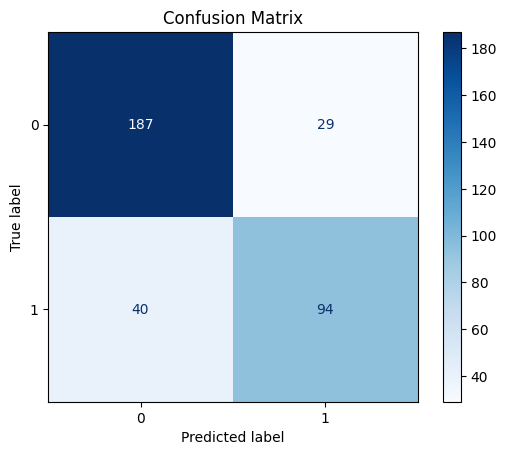

In [10]:
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(
    labelCol="Survived",
    featuresCol="features",
    maxIter=1500, 
    layers=[len(assembler.getInputCols()), 4, 2], 
    blockSize=128, 
    seed=1234
    )

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(valid)
predictionAndLabels = result.select("prediction", "Survived")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="Survived", predictionCol="prediction")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

# Get predictions
y_true = result.select("Survived").toPandas()
y_pred = result.select("prediction").toPandas()

# Create classification report
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [11]:
spark.stop()

# 5. Hyperparameter tuning

In [32]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_df['Sex'] = train_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
train_df['Embarked'] = train_df['Embarked'].apply(lambda x: 0 if x == 'S' else 1)

In [34]:
split_ratio = [[0.7, 0.3], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6], [0.3, 0.7]]
maxIters = [10, 100, 500, 1000, 1500, 1800]
layers = [[len(assembler.getInputCols()), 4, 2], [len(assembler.getInputCols()), 8, 4, 2], [len(assembler.getInputCols()), 32, 64, 16, 2]]
blockSizes = [16, 64, 128, 256]
for ratio in split_ratio:
    metrics_map = []
    for iter in maxIters:
        for layer in layers:
            for blkSize in blockSizes:
                metric = {}
                metric["maxIter"] = iter
                metric["layer"] = layer
                metric["blockSize"] = blkSize
                appName = "conbined_" + str(ratio[0]) + str(ratio[1]) + '_' + str(iter) + '_' + str(layer[1]) + '_' + str(blkSize)
                spark = SparkSession.builder.appName(name=appName).getOrCreate()
                
                data = spark.createDataFrame(train_df)
                assembler = VectorAssembler(inputCols = train_df.columns[1:].to_list(), outputCol = "features")
                data = assembler.transform(data)
                train, valid = data.randomSplit(ratio, seed=12345)
                y_true = valid.select('Survived').toPandas()
                y_true.to_csv(f'result/mlp/y_true_{int(ratio[0] * 100)}{int(ratio[1] * 100)}_{iter}_{layer[1]}_{blkSize}.csv', index=False)
                
                trainer = MultilayerPerceptronClassifier(labelCol="Survived", featuresCol="features", maxIter=iter, 
                                                        layers=layer, blockSize=blkSize, seed=1234)
                mlpModel = trainer.fit(train)
                mlpResult = mlpModel.transform(valid)
                mlp_y_pred = mlpResult.select('prediction').toPandas().values
                np.savetxt(f'result/mlp/y_pred_{int(ratio[0] * 100)}{int(ratio[1] * 100)}_{iter}_{layer[1]}_{blkSize}.csv', mlp_y_pred, delimiter=",")
                mlp_acc = accuracy_score(y_true, mlp_y_pred)
                metric['acc'] = mlp_acc
                mlp_f1 = f1_score(y_true, mlp_y_pred)
                metric['f1'] = mlp_f1
                mlp_precision = precision_score(y_true, mlp_y_pred)
                metric['precision'] = mlp_precision
                mlp_recall = recall_score(y_true, mlp_y_pred)
                metric['recall'] = mlp_recall

                metrics_map.append(metric)
                
                spark.stop()
                
    metrics_df = pd.DataFrame(metrics_map)
    metrics_df.to_csv(f'result/mlp/metrics_{int(ratio[0] * 100)}{int(ratio[1] * 100)}.csv', index=False)



24/11/29 02:01:42 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/11/29 02:02:27 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 02:04:02 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 02:04:03 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 02:04:03 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
24/11/29 02:04:03 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.125
24/11/29 02:04:03 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 02:05:30 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 02:05:30 ERROR

# Evaluation

In [3]:
result_map_7030 = pd.read_csv('result/mlp/metrics_7030.csv')
result_map_6040 = pd.read_csv('result/mlp/metrics_6040.csv')
result_map_5050 = pd.read_csv('result/mlp/metrics_5050.csv')
result_map_4060 = pd.read_csv('result/mlp/metrics_4060.csv')
result_map_3070 = pd.read_csv('result/mlp/metrics_3070.csv')

In [52]:
result_map_7030['ratio'] = '7030'
result_map_6040['ratio'] = '6040'
result_map_5050['ratio'] = '5050'
result_map_4060['ratio'] = '4060'
result_map_3070['ratio'] = '3070'
result_map = pd.concat([result_map_7030, result_map_6040, result_map_5050, result_map_4060, result_map_3070], ignore_index=True)
top_acc_map_7030 = result_map_7030.sort_values('acc', ascending=False)
top_acc_map_6040 = result_map_6040.sort_values('acc', ascending=False)
top_acc_map_5050 = result_map_5050.sort_values('acc', ascending=False)
top_acc_map_4060 = result_map_4060.sort_values('acc', ascending=False)
top_acc_map_3070 = result_map_3070.sort_values('acc', ascending=False)
top_acc_map = result_map.sort_values('acc', ascending=False)

In [53]:
top_acc_map_7030.head()

,maxIter,layer,blockSize,acc,f1,precision,recall,ratio
34,500,"[7, 32, 64, 16, 2]",128,0.812261,0.746114,0.800000,0.699029,7030
35,500,"[7, 32, 64, 16, 2]",256,0.812261,0.746114,0.800000,0.699029,7030
51,1500,"[7, 4, 2]",256,0.785441,0.705263,0.770115,0.650485,7030
50,1500,"[7, 4, 2]",128,0.785441,0.705263,0.770115,0.650485,7030
44,1000,"[7, 32, 64, 16, 2]",16,0.781609,0.710660,0.744681,0.679612,7030


In [54]:
top_acc_map_6040.head()

,maxIter,layer,blockSize,acc,f1,precision,recall,ratio
71,1800,"[7, 32, 64, 16, 2]",256,0.802857,0.731518,0.764228,0.701493,6040
50,1500,"[7, 4, 2]",128,0.802857,0.731518,0.764228,0.701493,6040
38,1000,"[7, 4, 2]",128,0.802857,0.731518,0.764228,0.701493,6040
39,1000,"[7, 4, 2]",256,0.802857,0.731518,0.764228,0.701493,6040
51,1500,"[7, 4, 2]",256,0.802857,0.731518,0.764228,0.701493,6040


In [55]:
top_acc_map_5050.head()

,maxIter,layer,blockSize,acc,f1,precision,recall,ratio
23,100,"[7, 32, 64, 16, 2]",256,0.815730,0.735484,0.808511,0.674556,5050
22,100,"[7, 32, 64, 16, 2]",128,0.815730,0.735484,0.808511,0.674556,5050
28,500,"[7, 8, 4, 2]",16,0.813483,0.743034,0.779221,0.710059,5050
69,1800,"[7, 32, 64, 16, 2]",64,0.808989,0.747774,0.750000,0.745562,5050
52,1500,"[7, 8, 4, 2]",16,0.806742,0.739394,0.757764,0.721893,5050


In [56]:
top_acc_map_4060.head()

,maxIter,layer,blockSize,acc,f1,precision,recall,ratio
49,1500,"[7, 4, 2]",64,0.820561,0.727273,0.853333,0.633663,4060
50,1500,"[7, 4, 2]",128,0.820561,0.727273,0.853333,0.633663,4060
51,1500,"[7, 4, 2]",256,0.820561,0.727273,0.853333,0.633663,4060
48,1500,"[7, 4, 2]",16,0.814953,0.737401,0.794286,0.688119,4060
63,1800,"[7, 4, 2]",256,0.814953,0.717949,0.845638,0.623762,4060


In [57]:
top_acc_map_3070.head()

,maxIter,layer,blockSize,acc,f1,precision,recall,ratio
23,100,"[7, 32, 64, 16, 2]",256,0.797125,0.731501,0.714876,0.748918,3070
21,100,"[7, 32, 64, 16, 2]",64,0.797125,0.731501,0.714876,0.748918,3070
22,100,"[7, 32, 64, 16, 2]",128,0.797125,0.731501,0.714876,0.748918,3070
35,500,"[7, 32, 64, 16, 2]",256,0.782748,0.697778,0.716895,0.679654,3070
34,500,"[7, 32, 64, 16, 2]",128,0.782748,0.697778,0.716895,0.679654,3070


In [58]:
top_acc_map.head()

,maxIter,layer,blockSize,acc,f1,precision,recall,ratio
266,1500,"[7, 4, 2]",128,0.820561,0.727273,0.853333,0.633663,4060
267,1500,"[7, 4, 2]",256,0.820561,0.727273,0.853333,0.633663,4060
265,1500,"[7, 4, 2]",64,0.820561,0.727273,0.853333,0.633663,4060
166,100,"[7, 32, 64, 16, 2]",128,0.815730,0.735484,0.808511,0.674556,5050
167,100,"[7, 32, 64, 16, 2]",256,0.815730,0.735484,0.808511,0.674556,5050
